# 6.3 Mini-project: Applying supervised learning to predict student dropout


#Libraries

In [3]:
#import relevant libraries
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, roc_auc_score, roc_curve,ConfusionMatrixDisplay, classification_report)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

pd.set_option('display.max_columns', None)



#Stage 1 data

## 1a. Data Exploration and pre-processing

In [11]:
# load the data - removed link for data protection purposes
df1 = pd.read_csv("")
#dropping information for data privacy reasons (for portfolio visuals only)
df1 = df1.drop(columns=['LearnerCode','HomeState','HomeCity','DateofBirth'],axis=1)

In [12]:
#load a sample of the dataset
print(df1.shape)
df1.sample(3)

(25059, 12)


,CentreName,BookingType,LeadSource,DiscountType,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity
14045,ISC_RHUL,Agent,Standard Agent Booking,Bursary,Male,Pakistani,International Year One,International Year One (Business and Managemen...,False,Yes,BSc (Hons) Business and Management,Royal Holloway
9583,ISC_Lancaster,Direct,Digital (Web),NaN,Male,Spanish,Foundation,Engineering and Computing Foundation Year,False,Yes,MSci Computer Science (with Industrial Experie...,Lancaster University
8840,ISC_LJMU,Agent,Sponsor,NaN,Male,Qatari,Foundation,Extended International Foundation Year: Engine...,False,Yes,BEng (Hons) Mechanical Engineering,Liverpool John Moores University


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   LearnerCode            25059 non-null  int64 
 2   BookingType            25059 non-null  object
 3   LeadSource             25059 non-null  object
 4   DiscountType           7595 non-null   object
 5   DateofBirth            25059 non-null  object
 6   Gender                 25059 non-null  object
 7   Nationality            25059 non-null  object
 8   HomeState              8925 non-null   object
 9   HomeCity               21611 non-null  object
 10  CourseLevel            25059 non-null  object
 11  CourseName             25059 non-null  object
 12  IsFirstIntake          25059 non-null  bool  
 13  CompletedCourse        25059 non-null  object
 14  ProgressionDegree      24184 non-null  object
 15  ProgressionUniversi

In [ ]:
#check for duplicate rows
duplicate_counts = df1.duplicated(keep=False).sum()
print('Duplicate rows:',duplicate_counts)

Duplicate rows: 0


In [ ]:
# convert DateofBirth to age
df1['DateofBirth'] = pd.to_datetime(df1['DateofBirth'],dayfirst=True)
df1['Age'] = (pd.Timestamp('now')-df1['DateofBirth']).dt.days//365

In [ ]:
#which columns have high cardinality
print('Columns with > 200 unique value:')
for column in df1.columns:
    if df1[column].nunique() > 200:
        print(column)

#columns with more than 50% data missing
print('\nColumns with greater than 50% of data missing:')
for column in df1.columns:
    if round(df1[column].isnull().sum()/df1[column].size*100)> 50:
        print(column)

#remove columns
df1 = df1.drop(columns=['LearnerCode','DateofBirth','HomeState','DiscountType','HomeCity','ProgressionDegree'],axis=1)

Columns with > 200 unique value:
LearnerCode
DateofBirth
HomeState
HomeCity
ProgressionDegree

Columns with greater than 50% of data missing:
DiscountType
HomeState


In [ ]:
#ordinal encode ordinal columns
list(df1['CourseLevel'].unique())

['Pre-Masters',
 'Foundation',
 'International Year Two',
 'International Year One']

In [ ]:
#create mappings for CourseLevel
mapping = {
    'Foundation': 1,
    'International Year One': 2,
    'International Year Two': 3,
    'Pre-Masters': 4
}
df1['CourseLevel'] = df1['CourseLevel'].map(mapping)

In [ ]:
#view the cleaned dataset
df1.sample(5)

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionUniversity,Age
9324,ISC_Lancaster,Agent,Standard Agent Booking,Male,Chinese,1,Business and Management Studies Foundation Year,False,Yes,Lancaster University,25
9033,ISC_LJMU,Direct,Digital (Web),Male,Malaysian,1,Business; Law and Social Studies International...,False,Yes,Liverpool John Moores University,23
7453,ISC_Kingston,Agent,Standard Agent Booking,Male,Bangladeshi,1,International Foundation Year - International ...,False,No,Kingston University London,26
18489,ISC_Sheffield,Agent,Standard Agent Booking,Male,Chinese,4,Pre-Masters Business; Social Sciences and Huma...,False,Yes,University of Sheffield International College,25
18200,ISC_Sheffield,Agent,Standard Agent Booking,Female,Chinese,4,Pre-Masters Business; Social Sciences and Huma...,False,Yes,University of Sheffield International College,26


In [ ]:
#one hot encode the remaining categorical columns
df1 = pd.get_dummies(df1,
                      columns = ['CentreName','BookingType','LeadSource','CourseName','IsFirstIntake','CompletedCourse','ProgressionUniversity','Nationality','Gender'],
                      drop_first=True).astype(int)


In [ ]:
print(df1.shape)
df1.describe()

(25059, 390)


,CourseLevel,Age,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,CentreName_ISC_Huddersfield,CentreName_ISC_Kingston,CentreName_ISC_LJMU,CentreName_ISC_Lancaster,CentreName_ISC_Leeds,CentreName_ISC_Lincoln,CentreName_ISC_London,CentreName_ISC_Online,CentreName_ISC_RHUL,CentreName_ISC_Sheffield,CentreName_ISC_Strathclyde,CentreName_ISC_Surrey,CentreName_ISC_Sussex,CentreName_ISC_Teesside,BookingType_Direct,LeadSource_Digital (Web),LeadSource_Re-enrolment,LeadSource_Referrals,LeadSource_Sponsor,LeadSource_Standard Agent Booking,LeadSource_Walk-in,CourseName_Accelerated International Foundation Year - Engineering; Physical Science and Computer Science,CourseName_Accelerated Pre-Masters,CourseName_Accelerated Pre-Masters Programme Business; Humanities; Social Sciences and Law (ICAS),CourseName_Accelerated Pre-Masters Programme Computing; Engineering and Health Sciences (ICAS),CourseName_Arts; Humanities; Law and Social Sciences - International Foundation Year,CourseName_Arts; Humanities; Law and Social Sciences International Foundation Year,CourseName_Business Management and Finance International Year Two,CourseName_Business Management and Finance International Year Two (ICAS),CourseName_Business and Law Pre-Masters,CourseName_Business and Law Pre-Masters (ICAS),CourseName_Business and Management Foundation Year (taught at the Holland ISC; in Amsterdam),CourseName_Business and Management Pre-Masters,CourseName_Business and Management Pre-Masters (January intake),CourseName_Business and Management Pre-Masters - ICAS,CourseName_Business and Management Studies Foundation Year,CourseName_Business and Media Foundation Year,CourseName_Business and Social Sciences Pre-Masters,CourseName_Business and Social Sciences Undergraduate Foundation Programme,CourseName_Business; Economics and Finance Foundation Year,CourseName_Business; Economics and Finance Foundation Year (Sponsored),CourseName_Business; Economics and Social Sciences Foundation Year,CourseName_Business; Economics; Accounting and Finance - International Foundation Year,CourseName_Business; Economics; Accounting and Finance International Foundation Year,CourseName_Business; Economics; Accounting and Finance Pre-Masters,CourseName_Business; Economics; Accounting and Real Estate Undergraduate Foundation Programme,CourseName_Business; Economics; Law and Social Sciences International Foundation Year,CourseName_Business; Law and Social Sciences Pre-Masters,CourseName_Business; Law and Social Studies International Foundation Year,CourseName_Business; Law and Social Studies International Foundation Year (November Intake),CourseName_Business; Management & Law Pre Masters - iCAS,CourseName_Business; Management; Accounting and Finance Foundation Year,CourseName_Business; Management; Accounting and Finance International Foundation Year,CourseName_Business; Management; Accounting and Finance International Year One,CourseName_Business; Management; Accounting and Finance Pre Masters,CourseName_Business; Management; Accounting and Finance Pre-Masters,CourseName_Business; Social Sciences and Humanities Foundation Year,CourseName_Business; Social Sciences and Humanities Pre-Masters,CourseName_Business; Social Sciences and Humanities Pre-Masters (2.5 Semesters),CourseName_CertHE International Foundation and Year One with Business (ICAS),CourseName_Computing Science International Year Two (ICAS),CourseName_Computing; Engineering and Physical Sciences International Foundation Year,CourseName_Engineering & Computing Pre Masters - iCAS,CourseName_Engineering Pre-Masters,CourseName_Engineering Pre-Masters (2.5 Semesters),CourseName_Engineering and Computing Foundation Year,CourseName_Engineering and Sciences Foundation Year,CourseName_Engineering and Sciences Foundation Year (Sponsored),CourseName_Engineering and Sciences Pre-Masters,CourseName_Engineering and Sciences Undergraduate Foundation Programme,CourseName_Engineering; Computing and Life Sciences Intern

In [ ]:
#set the X and y variables
X = df1.drop(columns=['CompletedCourse_Yes'])
y = df1['CompletedCourse_Yes']

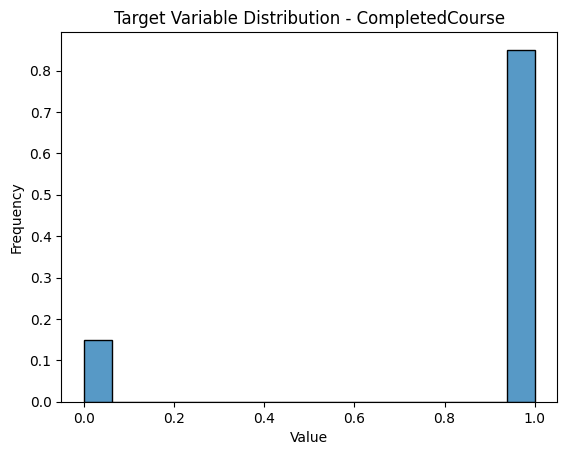

In [ ]:
#check the distribution of the target variable
sns.histplot(y,stat='probability')
plt.title('Target Variable Distribution - CompletedCourse')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Heavily imbalanced dataset, skewed towards the positive class, meaning students are more likely to complete than dropout.

##1b. XGBoost Model

In [ ]:
#split the dataset in to training and test sets
#ensure proportion of target variable is the same as in y, given that it's an imbalanced dataset
#want an 80-20 split
X_train_full, X_test, y_train_full, y_test= train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
#fit the XG boost model
xg_model = xgb.XGBClassifier(random_state=42)
xg_model.fit(X_train_full, y_train_full)

#create the predictions
y_pred_xg = xg_model.predict(X_test)
y_proba_xg = xg_model.predict_proba(X_test)[:,1]

Probability of positive based on distribution of y:  0.85
Accuracy       : 0.8957
Precision      : 0.9208
Recall         : 0.9599
AUC Score      : 0.8789


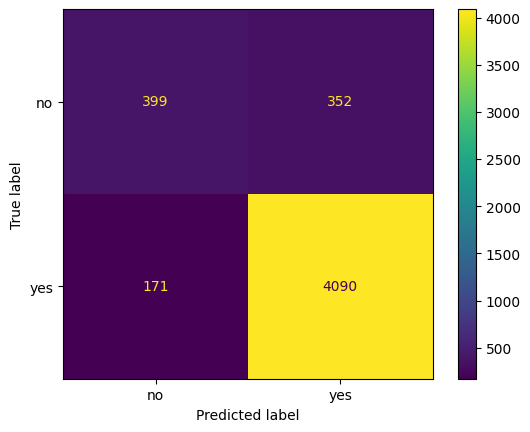

In [ ]:
#print the evaluation metrics and scores
accuracy_xg = accuracy_score(y_test, y_pred_xg)
conf_matrix_xg = confusion_matrix(y_test, y_pred_xg)
precision_xg = precision_score(y_test, y_pred_xg)
recall_xg = recall_score(y_test, y_pred_xg)
auc_xg = roc_auc_score(y_test, y_proba_xg)
positive_class_prob = y.value_counts(normalize=True).round(3).max()

# print probability of correctly predicting positive class
print('Probability of positive based on distribution of y: ',y.value_counts(normalize=True).round(3).max())

# print results
print(f"Accuracy       : {accuracy_xg:.4f}")
print(f"Precision      : {precision_xg:.4f}")
print(f"Recall         : {recall_xg:.4f}")
print(f"AUC Score      : {auc_xg:.4f}")

cfmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xg, display_labels=["no","yes"])
cfmd.plot()
plt.show()


Given the imbalanced dataset, if we were to always predict the positive class, we would be right 85% of the time, therefore our model must outperform this.

Following XGBoost with no tuning:
- The model is accurate around 90% of the time.
- 8% false positives
- Only 4% of positives were missed
- AUC of 88%

Although this looks good, given the highly imbalanced dataset, we should look to see if we can improve performance.

##1c. XGBoost Tuning

In [ ]:
#hyperparameter tuning
param_grid={
            'n_estimators': [100,200,50],
            'max_depth':[3,5,10],
            'learning_rate': [0.01,0.1]
            }
#want to use stratified k fold to recognise the rare positives
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#all possible combinations of hyperparameters to test
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=skf,
    scoring='roc_auc'#because the dataset is very imbalanced, optimising using roc_auc instead of accuracy
)

#fit on the trianing data
grid_search.fit(X_train_full, y_train_full)
best_params= grid_search.best_params_
#print the results
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


Accuracy       : 0.8962
Precision      : 0.9193
Recall         : 0.9625
AUC Score      : 0.8790


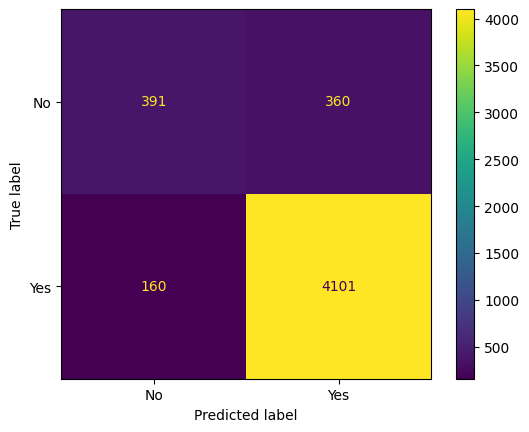

In [ ]:
#run the xg boost model with best parameters
xg_model_tuned = xgb.XGBClassifier(**best_params, random_state=42)
xg_model_tuned.fit(X_train_full, y_train_full)

#create the predictions
y_pred_tuned = xg_model_tuned.predict(X_test)
y_proba_tuned = xg_model_tuned.predict_proba(X_test)[:,1]

#evaluation metrics and scores
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_proba_tuned)

# print evaluation metrics
print(f"Accuracy       : {accuracy_tuned:.4f}")
print(f"Precision      : {precision_tuned:.4f}")
print(f"Recall         : {recall_tuned:.4f}")
print(f"AUC Score      : {auc_tuned:.4f}")


cfmd_xg_tuned = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned, display_labels=["No", "Yes"])
cfmd_xg_tuned.plot()
plt.show()


In [ ]:
# compare performance of original model vs model following hyperparameter tuning
print(f"Accuracy:\nOriginal:{accuracy_xg:.4f}, Tuned:{accuracy_tuned:.4f}")
if accuracy_xg > accuracy_tuned:
    print("Original model is more accurate")
else:
    print("Improved accuracy following tuning")
print(f"\nPrecision:\nOriginal:{precision_xg:.4f}, Tuned:{precision_tuned:.4f}")
if precision_xg > precision_tuned:
    print("Original model achieves a higher precision metric")
else:
    print("Improved precision following tuning")
print(f"\nRecall:\nOriginal:{recall_xg:.4f}, Tuned:{recall_tuned:.4f}")
if recall_xg > recall_tuned:
    print("Original model achieves a higher recall metric")
else:
    print("Improved recall following tuning")
print(f"\nAUC Score:\nOriginal:{auc_xg:.4f}, Tuned:{auc_tuned:.4f}")
if auc_xg > auc_tuned:
    print("Original model achieves a higher AUC score")
else:
    print("Improved AUC score following tuning")


Accuracy:
Original:0.8957, Tuned:0.8962
Improved accuracy following tuning

Precision:
Original:0.9208, Tuned:0.9193
Original model achieves a higher precision metric

Recall:
Original:0.9599, Tuned:0.9625
Improved recall following tuning

AUC Score:
Original:0.8789, Tuned:0.8790
Improved AUC score following tuning


I am choosing to focus on roc auc score due to the imbalanced nature of the dataset. This measures the trade off between TPR and FPR so does not get skewed by the imbalance.

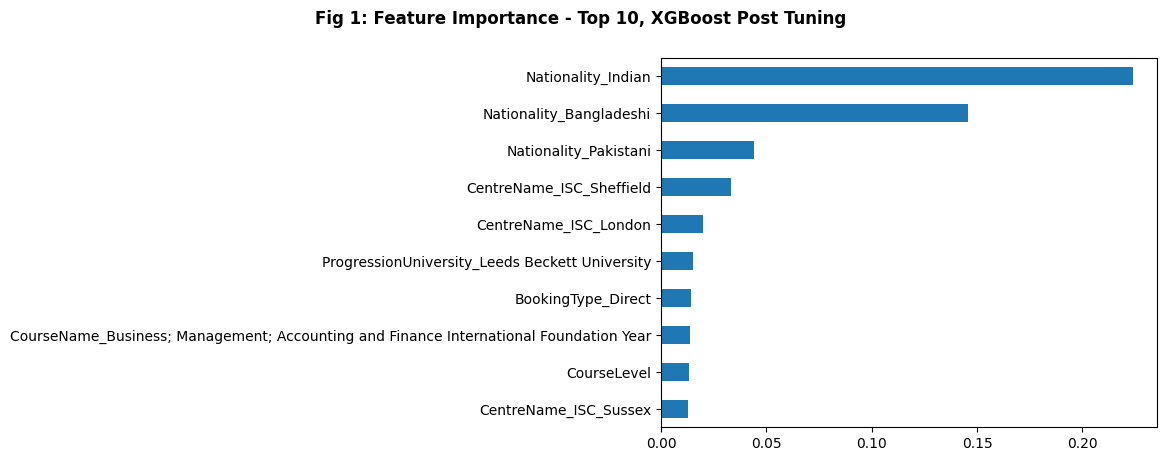

In [ ]:
#look at feature importance
# given high dimensional dataset, printing only the 10 most important
feature_importance = pd.Series(xg_model_tuned.feature_importances_, index=X_train_full.columns).sort_values()
feature_importance.iloc[-10:].plot.barh()
plt.suptitle('Fig 1: Feature Importance - Top 10, XGBoost Post Tuning',x=0,fontweight='bold')
plt.show()

While feature importance does not indicate the magnitude or the direction of a features influence on the target variable, the plot above indicates that Bangladeshi, Indian and Pakistani nationals are the most important when predicting whether a student will drop out or not.

##1d. Neural Network

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
# we now want to compare performance using a neural network, to see if this can better predict a student dropping out
# given we already split the dataset above we can use the training and test sets created earlier
# split the training and test set further to get validation sets, with an 80/20 split.
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,stratify=y_train_full, random_state=42,test_size=0.2)

# neural networks are sensitive to scale, therefore need to standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [ ]:
#define the neural network
#given it is a binary classification problem, we will use binary_crossentropy as the loss function, and sigmoid activation function in output layer
neural_model = Sequential()
neural_model.add(Input(shape=(X_train_scaled.shape[1],)))
neural_model.add(Dense(32, activation='relu'))
neural_model.add(Dense(1, activation='sigmoid')) #as binary classification one output neuron only

#compile the model
neural_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

#fit the model with 80/20 split for validation
history = neural_model.fit(X_train_scaled, y_train,
                 batch_size=32,
                 epochs=30,
                 validation_data=(X_val_scaled,y_val),
                 verbose=1)

Epoch 1/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8333 - loss: 0.4214 - val_accuracy: 0.8933 - val_loss: 0.2776
Epoch 2/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8939 - loss: 0.2761 - val_accuracy: 0.8970 - val_loss: 0.2723
Epoch 3/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8952 - loss: 0.2638 - val_accuracy: 0.8978 - val_loss: 0.2710
Epoch 4/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8975 - loss: 0.2576 - val_accuracy: 0.8995 - val_loss: 0.2706
Epoch 5/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8993 - loss: 0.2536 - val_accuracy: 0.8990 - val_loss: 0.2707
Epoch 6/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9007 - loss: 0.2502 - val_accuracy: 0.8978 - val_loss: 0.2713
Epoch 7/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9012 - loss: 0.2472 - val_accuracy: 0.8988 - val_loss: 0.2718
Epoch 8/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9018 - loss: 0.2445 - val_accuracy: 0.

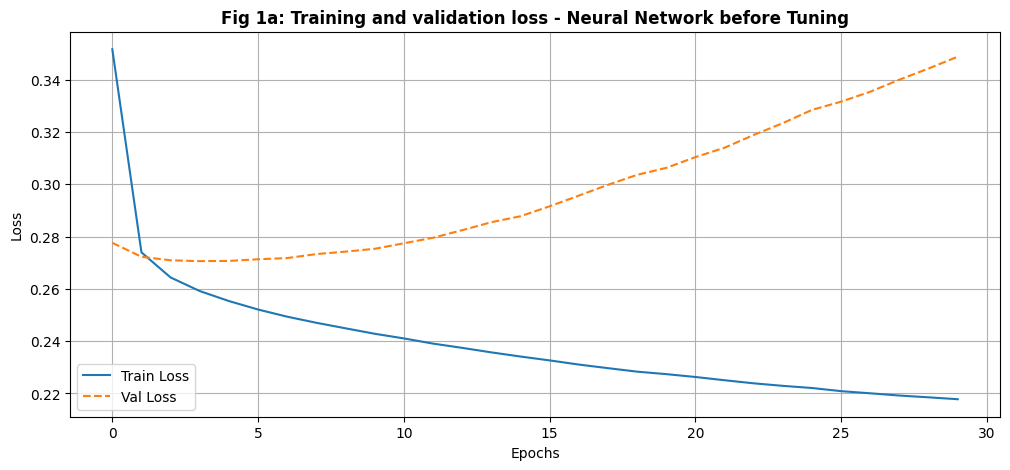

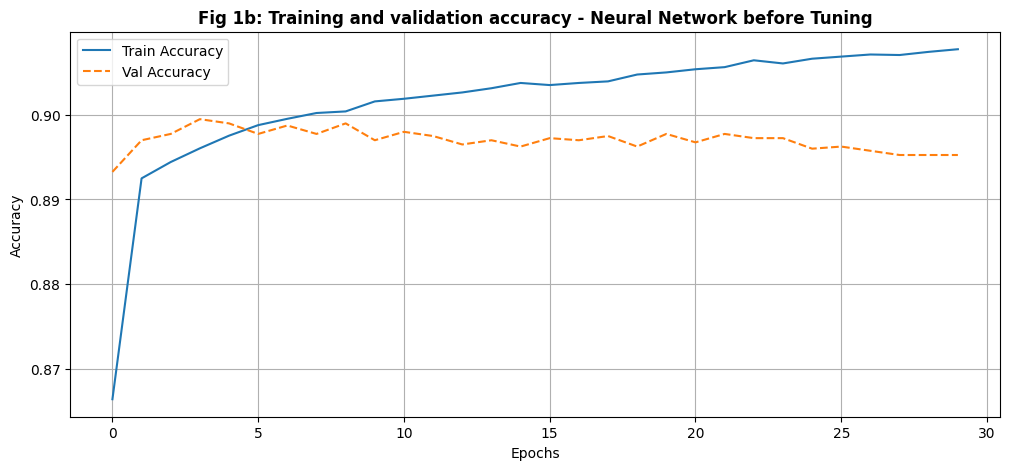

In [ ]:
# plot train/validation loss.
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label=f"Train Loss")
plt.plot(history.history['val_loss'], linestyle='--', label=f"Val Loss")
plt.title('Fig 1a: Training and validation loss - Neural Network before Tuning',fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# plot train/validation loss.
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label=f"Train Accuracy")
plt.plot(history.history['val_accuracy'], linestyle='--', label=f"Val Accuracy")
plt.title('Fig 1b: Training and validation accuracy - Neural Network before Tuning',fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Results show that overfitting begins occuring past the fourth epoch as the validation loss begins to increase, and the training loss continues to decrease. This suggests the training set is beginning to memorise the noise.
The accuracy does not improve much either past this point, suggesting to cut the number of epochs off at 4 for the current model configuration.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Probability of positive based on distribution of y_test: 0.85
Accuracy       : 0.8891
Precision      : 0.9202
Recall         : 0.9521
AUC Score      : 0.8561


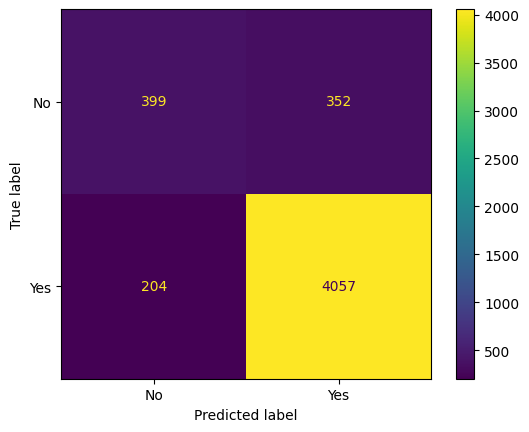

In [ ]:
# predict probabilities for positive class
y_proba_nn = neural_model.predict(X_test_scaled).ravel()

# convert probabilities to binary predictions using 0.5 threshold
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

#evaluation metrics
accuracy_nn = accuracy_score(y_test, y_pred_nn)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
auc_nn = roc_auc_score(y_test, y_proba_nn)

print('Probability of positive based on distribution of y_test:', y_test.value_counts(normalize=True).get(1, 0).round(3))

# print evaluation metrics
print(f"Accuracy       : {accuracy_nn:.4f}")
print(f"Precision      : {precision_nn:.4f}")
print(f"Recall         : {recall_nn:.4f}")
print(f"AUC Score      : {auc_nn:.4f}")

cfmd_nn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nn, display_labels=["No", "Yes"])
cfmd_nn.plot()
plt.show()


##1e. Neural Network Tuning

In [ ]:
#hyperparameter tuning
param_grid_nn={
            'num_hidden_layers': [1,3,5],
            'num_neurons':[16,32,64],
            'optimizer': ['Adam','RMSProp'],
            'activation':['relu','tanh']
            }

best_auc_nn = 0
best_model_nn = None
best_params_nn ={}

#set early stopping criteria to save training time and computational cost
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#grid search
for layers in param_grid_nn['num_hidden_layers']:
    for neurons in param_grid_nn['num_neurons']:
        for opt in param_grid_nn['optimizer']:
            for act in param_grid_nn['activation']:

                print(f"Training model: layers={layers}, neurons={neurons}, optimizer={opt}, activation={act}")

                model = Sequential()
                model.add(Input(shape=(X_train_scaled.shape[1],)))
                for _ in range(layers):
                    model.add(Dense(neurons, activation=act))
                model.add(Dense(1, activation='sigmoid'))

                model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

                # fit model
                model.fit(X_train_scaled, y_train,
                          validation_data=(X_val_scaled, y_val),
                          epochs=30,
                          batch_size=32,
                          callbacks=[early_stopping],
                          verbose=0)

                # predict on validation set
                y_val_proba = model.predict(X_val_scaled).ravel()
                auc = roc_auc_score(y_val, y_val_proba)

                print(f"AUC: {auc:.4f}")

                # save best model
                if auc > best_auc_nn:
                    best_auc_nn = auc
                    best_model_nn = model
                    best_params_nn = {
                        'num_hidden_layers': layers,
                        'num_neurons': neurons,
                        'optimizer': opt,
                        'activation': act}


Training model: layers=1, neurons=16, optimizer=Adam, activation=relu
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC: 0.8803
Training model: layers=1, neurons=16, optimizer=Adam, activation=tanh
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8826
Training model: layers=1, neurons=16, optimizer=RMSProp, activation=relu
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC: 0.8831
Training model: layers=1, neurons=16, optimizer=RMSProp, activation=tanh
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8799
Training model: layers=1, neurons=32, optimizer=Adam, activation=relu
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC: 0.8840
Training model: layers=1, neurons=32, optimizer=Adam, activation=tanh
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8864
Training model: layers=1, neurons=32, optimizer=RMSProp, activation=relu
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8823
Training model: layers=1, neurons=32, optimizer=RMSProp, activation=tanh
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8793
Trai

In [ ]:
#print optimal config
print("\nBest hyperparameters:")
print(best_params_nn)
print(f"Best validation AUC: {best_auc_nn:.4f}")


Best hyperparameters:
{'num_hidden_layers': 1, 'num_neurons': 64, 'optimizer': 'RMSProp', 'activation': 'tanh'}
Best validation AUC: 0.8866


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


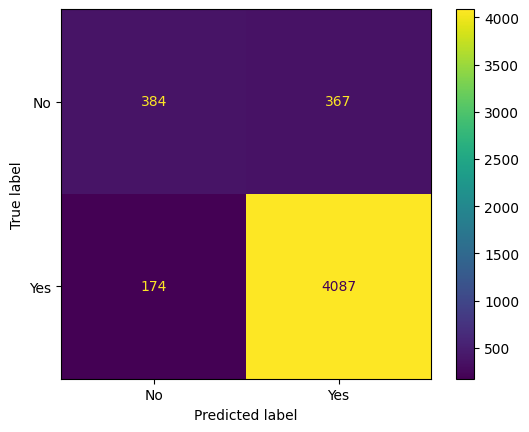

In [ ]:
#create the predictions
y_proba_tuned_nn = best_model_nn.predict(X_test_scaled).ravel()
y_pred_tuned_nn = (y_proba_tuned_nn >= 0.5).astype(int)

#evaluation metrics and scores
accuracy_tuned_nn = accuracy_score(y_test, y_pred_tuned_nn)
conf_matrix_tuned_nn = confusion_matrix(y_test, y_pred_tuned_nn)
precision_tuned_nn = precision_score(y_test, y_pred_tuned_nn)
recall_tuned_nn = recall_score(y_test, y_pred_tuned_nn)
auc_tuned_nn = roc_auc_score(y_test, y_proba_tuned_nn)

cfmd_nn_tuned = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned_nn, display_labels=["No", "Yes"])
cfmd_nn_tuned.plot()
plt.show()

In [ ]:
# compare performance of original model vs model following hyperparameter tuning
print(f"Accuracy:\nOriginal:{accuracy_nn:.4f}, Tuned:{accuracy_tuned_nn:.4f}")
if accuracy_nn > accuracy_tuned_nn:
    print("Original model is more accurate")
else:
    print("Improved accuracy following tuning")
print(f"\nPrecision:\nOriginal:{precision_nn:.4f}, Tuned:{precision_tuned_nn:.4f}")
if precision_nn > precision_tuned_nn:
    print("Original model achieves a higher precision metric")
else:
    print("Improved precision following tuning")
print(f"\nRecall:\nOriginal:{recall_nn:.4f}, Tuned:{recall_tuned_nn:.4f}")
if recall_nn > recall_tuned_nn:
    print("Original model achieves a higher recall metric")
else:
    print("Improved recall following tuning")
print(f"\nAUC Score:\nOriginal:{auc_nn:.4f}, Tuned:{auc_tuned_nn:.4f}")
if auc_nn > auc_tuned_nn:
    print("Original model achieves a higher AUC score")
else:
    print("Improved AUC score following tuning")


Accuracy:
Original:0.8891, Tuned:0.8921
Improved accuracy following tuning

Precision:
Original:0.9202, Tuned:0.9176
Original model achieves a higher precision metric

Recall:
Original:0.9521, Tuned:0.9592
Improved recall following tuning

AUC Score:
Original:0.8561, Tuned:0.8708
Improved AUC score following tuning


##Data Exports

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

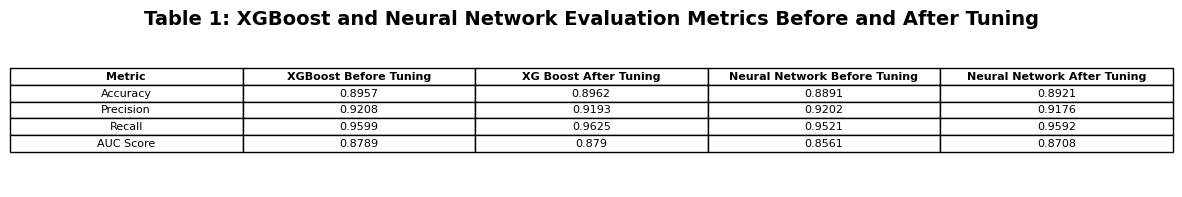

In [ ]:
#create table that can be exported in to report
metrics_stage1 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC Score'],
    'XGBoost Before Tuning': [round(accuracy_xg,4), round(precision_xg,4), round(recall_xg,4), round(auc_xg,4)],
    'XG Boost After Tuning': [round(accuracy_tuned,4), round(precision_tuned,4), round(recall_tuned,4), round(auc_tuned,4)],
    'Neural Network Before Tuning': [round(accuracy_nn,4), round(precision_nn,4), round(recall_nn,4), round(auc_nn,4)],
    'Neural Network After Tuning': [round(accuracy_tuned_nn,4), round(precision_tuned_nn,4), round(recall_tuned_nn,4), round(auc_tuned_nn,4)]
}
df_metrics_stage1 = pd.DataFrame(metrics_stage1)

fig, ax = plt.subplots(figsize=(15, 2))
ax.axis('tight')
ax.axis('off')

# Display the DataFrame as a table with specific formatting
table = ax.table(cellText=df_metrics_stage1.values, colLabels=df_metrics_stage1.columns, loc='center', cellLoc='center')

# make column headers bold
for (i, j) in zip(range(len(df_metrics_stage1.columns)), range(len(df_metrics_stage1.columns))):
    table[0, j].set_fontsize(14)
    table[0, j].set_text_props(weight='bold')

# adjust row height for better spacing
for i in range(len(df_metrics_stage1.index)):
    table[i+1, 0].set_fontsize(14)
    table[i+1, 1].set_fontsize(14)
    table[i+1, 2].set_fontsize(14)
    table[i+1, 3].set_fontsize(14)
    table[i+1, 4].set_fontsize(14)

plt.title('Table 1: XGBoost and Neural Network Evaluation Metrics Before and After Tuning', fontsize=14,fontweight='bold')
plt.savefig('metrics_stage1_table.png', bbox_inches='tight', dpi=300)
# download image

save_path = '/content/metrics_stage1_table.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)
files.download(save_path)

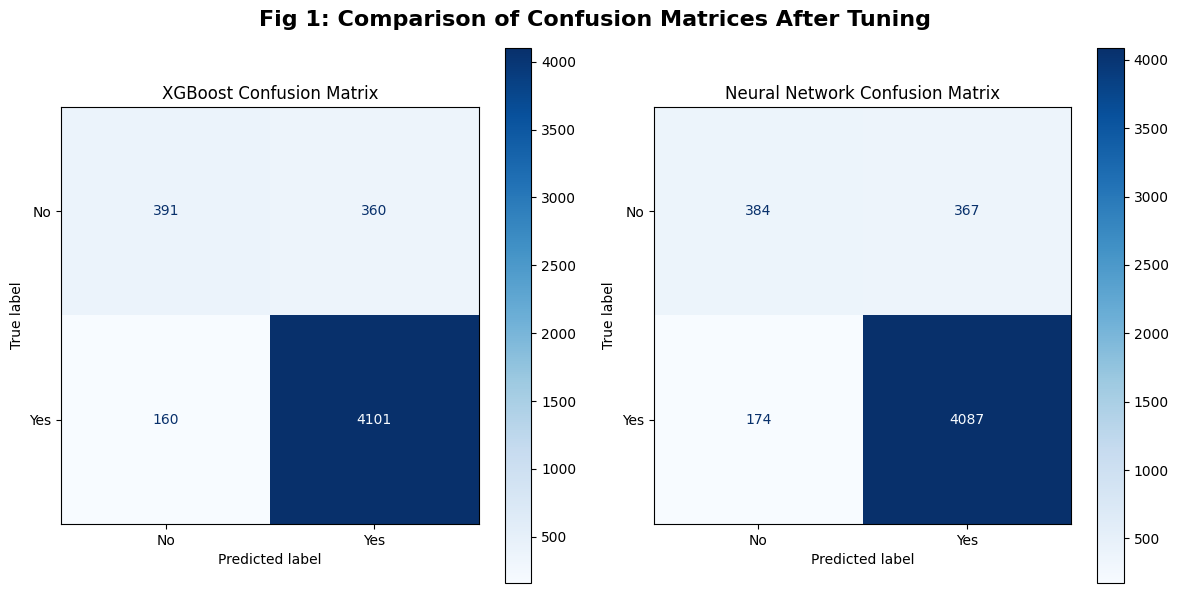

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
#plot the confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cfmd_xg_tuned.plot(ax=axes[0], cmap='Blues', values_format='d')
cfmd_nn_tuned.plot(ax=axes[1], cmap='Blues', values_format='d')

# set titles for both subplots
axes[0].set_title('XGBoost Confusion Matrix')
axes[1].set_title('Neural Network Confusion Matrix')

#add title for master plot
plt.suptitle('Fig 1: Comparison of Confusion Matrices After Tuning', fontsize=16, fontweight='bold')

plt.tight_layout()
# Show the plot
plt.show()

plt.savefig('cfm_stage1_table.png', bbox_inches='tight', dpi=150)
# download image

save_path = '/content/cfm_stage1_table.png'
plt.savefig(save_path, bbox_inches='tight', dpi=150)
files.download(save_path)


# Stage 2 data

##2a. Data Exploration and Pre-Processing

In [15]:
# load the data - removing link for data protection
df2 = pd.read_csv("")
#dropping information for data privacy reasons (for portfolio visuals only)
df2 = df2.drop(columns=['LearnerCode','HomeState','HomeCity','DateofBirth'],axis=1)

In [16]:
#load a sample of the dataset
print(df2.shape)
df2.sample(3)

(25059, 14)


,CentreName,BookingType,LeadSource,DiscountType,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
19166,ISC_Sheffield,Agent,Standard Agent Booking,NaN,Male,Chinese,Foundation,International Foundation Year Science and Engi...,False,Yes,BEng (Hons) Mechatronic and Robotic Engineering,University of Sheffield International College,0.0,28.0
24364,ISC_Sussex,Agent,Standard Agent Booking,Bursary,Female,Zambian,Foundation,International Foundation Year Business; Media ...,False,Yes,LLB (Hons) Law,University of Sussex,41.0,62.0
256,ISC_Aberdeen,Direct,Sponsor,Other Scholarships / Bursaries,Male,Omani,Foundation,Life Sciences - pathway to Medicine Undergradu...,False,No,NaN,University of Aberdeen,0.0,1.0


In [ ]:
#check for duplicate rows
duplicate_counts = df2.duplicated(keep=False).sum()
print('Duplicate rows:',duplicate_counts)

Duplicate rows: 0


In [ ]:
# convert DateofBirth to age
df2['DateofBirth'] = pd.to_datetime(df2['DateofBirth'],dayfirst=True)
df2['Age'] = (pd.Timestamp('now')-df2['DateofBirth']).dt.days//365

In [ ]:
#which columns have high cardinality
print('Columns with > 200 unique value:')
for column in df2.columns:
    if df2[column].nunique() > 200:
        print(column)

#columns with more than 50% data missing
print('\nColumns with greater than 50% of data missing:')
for column in df2.columns:
    if round(df2[column].isnull().sum()/df2[column].size*100)> 50:
        print(column)

#remove columns
df2 = df2.drop(columns=['LearnerCode','DateofBirth','HomeState','DiscountType','HomeCity','ProgressionDegree','UnauthorisedAbsenceCount'],axis=1)

Columns with > 200 unique value:
LearnerCode
DateofBirth
HomeState
HomeCity
ProgressionDegree
UnauthorisedAbsenceCount

Columns with greater than 50% of data missing:
DiscountType
HomeState


In [ ]:
#view cleaned data frame
df2.sample(3)

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionUniversity,AuthorisedAbsenceCount,Age
16189,ISC_Sheffield,Agent,Sponsor,Male,Kuwaiti,Foundation,Science and Engineering Foundation Year,False,Yes,University of Sheffield International College,0.0,24
12808,ISC_London,Agent,Standard Agent Booking,Male,Bangladeshi,Foundation,Business; Management; Accounting and Finance F...,False,Yes,Coventry University London,83.0,23
16571,ISC_Sheffield,Agent,Standard Agent Booking,Male,Hong Kong Chinese,Foundation,Business; Social Sciences and Humanities Found...,False,Yes,University of Sheffield International College,1.0,23


In [ ]:
#ordinal encode ordinal columns
#create mappings for CourseLevel
mapping = {
    'Foundation': 1,
    'International Year One': 2,
    'International Year Two': 3,
    'Pre-Masters': 4
}
df2['CourseLevel'] = df2['CourseLevel'].map(mapping)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CentreName              25059 non-null  object 
 1   BookingType             25059 non-null  object 
 2   LeadSource              25059 non-null  object 
 3   Gender                  25059 non-null  object 
 4   Nationality             25059 non-null  object 
 5   CourseLevel             25059 non-null  int64  
 6   CourseName              25059 non-null  object 
 7   IsFirstIntake           25059 non-null  bool   
 8   CompletedCourse         25059 non-null  object 
 9   ProgressionUniversity   25059 non-null  object 
 10  AuthorisedAbsenceCount  24851 non-null  float64
 11  Age                     25059 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 2.1+ MB


In [ ]:
#missing values for AuthorisedAbsentCount, what percentage is missing?
print('Precent of dataset missing per feature')
round(df2[['AuthorisedAbsenceCount']].isnull().sum()/25059*100,2)

Precent of dataset missing per feature


,0
AuthorisedAbsenceCount,0.83


Text(0.5, 1.0, 'Fig 2: Distribution of New Column - AuthorisedAbsenceCount')

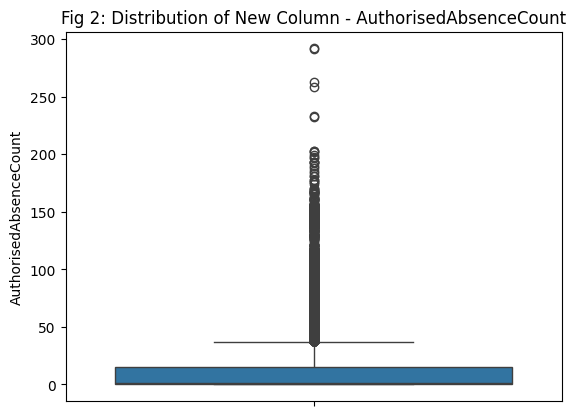

In [ ]:
#view the distribution of AuthorisedAbsenceCount
sns.boxplot(df2['AuthorisedAbsenceCount'])
plt.title('Fig 2: Distribution of New Column - AuthorisedAbsenceCount')

Text(0.5, 1.0, 'Distribution of AuthorisedAbsenceCount')

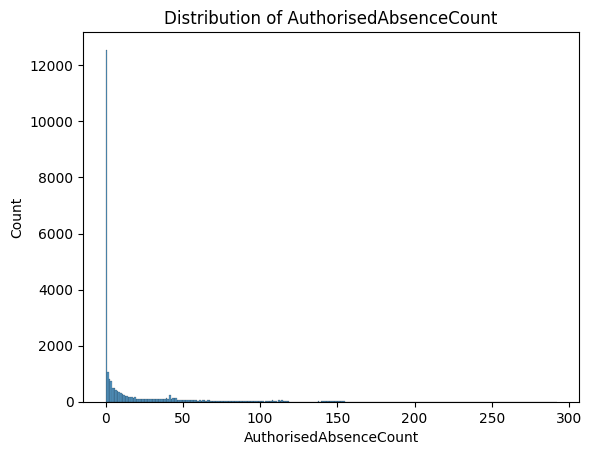

In [ ]:
#view the distribution of AuthorisedAbsenceCount
sns.histplot(df2['AuthorisedAbsenceCount'])
plt.title('Distribution of AuthorisedAbsenceCount')

In [ ]:
#what is the median value given course level and gender
abs_by_course_gender = df2.groupby(['Gender', 'CourseLevel'])['AuthorisedAbsenceCount'].median()
abs_by_course_gender

Gender  CourseLevel
Female  1               3.0
        2               4.0
        3              17.0
        4               0.0
Male    1               2.0
        2               2.0
        3               4.0
        4               0.0
Name: AuthorisedAbsenceCount, dtype: float64

In [ ]:
# fill the missing values in AuthorisedAbsence with the medians of gender and courselevel groups
df2['AuthorisedAbsenceCount'] = df2.groupby(['Gender', 'CourseLevel'], group_keys=False)['AuthorisedAbsenceCount'].apply(lambda x: x.fillna(x.median()))

In [ ]:
#check that nulls have been imputed
df2.isnull().sum()

,0
CentreName,0
BookingType,0
LeadSource,0
Gender,0
Nationality,0
CourseLevel,0
CourseName,0
IsFirstIntake,0
CompletedCourse,0
ProgressionUniversity,0


In [ ]:
#one hot encode the remaining categorical columns
df2 = pd.get_dummies(df2,
                      columns = ['CentreName','BookingType','LeadSource','CourseName','IsFirstIntake','CompletedCourse','ProgressionUniversity','Nationality','Gender'],
                      drop_first=True).astype(int)

In [ ]:
X2 = df2.drop(columns=['CompletedCourse_Yes'])
y2 = df2['CompletedCourse_Yes']

##2b. XGBoost

In [ ]:
#split the dataset using the new df with extra column
X2_train_full, X2_test, y2_train_full, y2_test = train_test_split(X2, y2, stratify=y2, test_size=0.2, random_state=42)
#run the xg boost model with best parameters from the previous stage
xg_model_df2 = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
xg_model_df2.fit(X2_train_full, y2_train_full)

#create the predictions
y2_pred = xg_model_df2.predict(X2_test)
y2_proba = xg_model_df2.predict_proba(X2_test)[:, 1]

#evaluation metrics and scores
accuracy_xg_df2 = accuracy_score(y2_test, y2_pred)
precision_xg_df2 = precision_score(y2_test, y2_pred)
recall_xg_df2 = recall_score(y2_test, y2_pred)
auc_xg_df2 = roc_auc_score(y2_test, y2_proba)

# compare performance of original model vs model following hyperparameter tuning
print(f"Accuracy:\nStage 1: {accuracy_tuned:.4f}, Stage 2: {accuracy_xg_df2:.4f}")
if accuracy_tuned > accuracy_xg_df2:
    print("Stage 1 model is more accurate")
else:
    print("Improved accuracy using stage 2 data")
print(f"\nPrecision:\nStage 1: {precision_tuned:.4f}, Stage 2: {precision_xg_df2:.4f}")
if precision_tuned > precision_xg_df2:
    print("Stage 1 model achieves a higher precision metric")
else:
    print("Improved precision using stage 2 data")
print(f"\nRecall:\nStage 1: {recall_tuned:.4f}, Stage 2: {recall_xg_df2:.4f}")
if recall_tuned > recall_xg_df2:
    print("Stage 1 model achieves a higher recall metric")
else:
    print("Improved recall using stage 2 data")
print(f"\nAUC Score:\nStage 1: {auc_tuned:.4f}, Stage 2: {auc_xg_df2:.4f}")
if auc_tuned > auc_xg_df2:
    print("Stage 1 model achieves a higher AUC score")
else:
    print("Improved AUC score using stage 2 data")


Accuracy:
Stage 1: 0.8962, Stage 2: 0.8984
Improved accuracy using stage 2 data

Precision:
Stage 1: 0.9193, Stage 2: 0.9223
Improved precision using stage 2 data

Recall:
Stage 1: 0.9625, Stage 2: 0.9615
Stage 1 model achieves a higher recall metric

AUC Score:
Stage 1: 0.8790, Stage 2: 0.8965
Improved AUC score using stage 2 data


XGBoost performs better using the stage 2 dataset in terms of Accuracy, Precision, and AUC Score, however worse when observing the recall metric. This would indicate that although there are fewer mistakes using stage 2 data, and there are fewer false positives, lower recall indicates that the model is missing more dropouts. However, given the difference is marginal, in comparison to the improvement in the other metrics, I would suggest stage 2 is an improved model.

##2c. XGBoost Tuning

In [ ]:
#all possible combinations of hyperparameters to test
grid_search_df2 = GridSearchCV(
    estimator=xg_model_df2,
    param_grid=param_grid,
    cv=skf,
    scoring='roc_auc'#because the dataset is very imbalanced, optimising using roc_auc instead of accuracy
)

#fit on the new training dataset
grid_search_df2.fit(X2_train_full, y2_train_full)
print("Best Parameters:", grid_search_df2.best_params_)

#run the xg boost model with best parameters
xg_model_tuned_xg_df2 = xgb.XGBClassifier(**grid_search_df2.best_params_, random_state=42)
xg_model_tuned_xg_df2.fit(X2_train_full, y2_train_full)

#create the predictions
y_pred_tuned_xg_df2 = xg_model_tuned_xg_df2.predict(X2_test)
y_proba_tuned_xg_df2 = xg_model_tuned_xg_df2.predict_proba(X2_test)[:,1]

#evaluation metrics and scores
accuracy_tuned_xg_df2 = accuracy_score(y2_test, y_pred_tuned_xg_df2)
conf_matrix_tuned_xg_df2 = confusion_matrix(y2_test, y_pred_tuned_xg_df2)
precision_tuned_xg_df2 = precision_score(y2_test, y_pred_tuned_xg_df2)
recall_tuned_xg_df2 = recall_score(y2_test, y_pred_tuned_xg_df2)
auc_tuned_xg_df2 = roc_auc_score(y2_test, y_proba_tuned_xg_df2)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


In [ ]:
# compare performance of original model vs model following hyperparameter tuning
print(f"Accuracy:\nOriginal:{accuracy_xg_df2:.4f}, Tuned:{accuracy_tuned_xg_df2:.4f}")
if accuracy_xg_df2 > accuracy_tuned_xg_df2:
    print("Original model is more accurate")
else:
    print("Improved accuracy following tuning")
print(f"\nPrecision:\nOriginal:{precision_xg_df2:.4f}, Tuned:{precision_tuned_xg_df2:.4f}")
if precision_xg_df2 > precision_tuned_xg_df2:
    print("Original model achieves a higher precision metric")
else:
    print("Improved precision following tuning")
print(f"\nRecall:\nOriginal:{recall_xg_df2:.4f}, Tuned:{recall_tuned_xg_df2:.4f}")
if recall_xg_df2 > recall_tuned_xg_df2:
    print("Original model achieves a higher recall metric")
else:
    print("Improved recall following tuning")
print(f"\nAUC Score:\nOriginal:{auc_xg_df2:.4f}, Tuned:{auc_tuned_xg_df2:.4f}")
if auc_xg_df2 > auc_tuned_xg_df2:
    print("Original model achieves a higher AUC score")
else:
    print("Improved AUC score following tuning")


Accuracy:
Original:0.8984, Tuned:0.9012
Improved accuracy following tuning

Precision:
Original:0.9223, Tuned:0.9262
Improved precision following tuning

Recall:
Original:0.9615, Tuned:0.9603
Original model achieves a higher recall metric

AUC Score:
Original:0.8965, Tuned:0.8951
Original model achieves a higher AUC score


The tuned model achieves a higher accuracy and precision metric, though a lower recall and AUC score. Given the config for stage 1 is an option, and performance varies only slightly, this suggests the randomness of the model is what causes the change in optimal hyperparameters.

##2d. Neural Network

In [ ]:
# run the neural network with the tuned parameters in stage 1, on the stage 2 dataset
print('Tuned best parameters in stage 1:',best_params_nn)

Tuned best parameters in stage 1: {'num_hidden_layers': 1, 'num_neurons': 64, 'optimizer': 'RMSProp', 'activation': 'tanh'}


In [ ]:
set_seed = np.random.seed(42)
tf.random.set_seed(42)

# split the training and test set further to get validation sets, with an 80/20 split, using the new dataset
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train_full, y2_train_full, stratify=y2_train_full, test_size=0.2, random_state=42)

scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_val_scaled = scaler2.transform(X2_val)
X2_test_scaled = scaler2.transform(X2_test)

#set early stopping criteria to save training time and computational cost
early_stopping2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#create and fit the model using the best parameters found in stage 1, using stage 2 data
nn_model_df2 = Sequential()
nn_model_df2.add(Input(shape=(X2_train_scaled.shape[1],)))
nn_model_df2.add(Dense(64, activation='tanh'))
nn_model_df2.add(Dense(1, activation='sigmoid'))
nn_model_df2.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])
nn_model_df2.fit(X2_train_scaled, y2_train,
                 validation_data=(X2_val_scaled, y2_val),
                 epochs=30,
                 batch_size=32,
                 callbacks=[early_stopping2],
                 verbose=0)

#create the predictions
y2_proba_nn = nn_model_df2.predict(X2_test_scaled).ravel()
y2_pred_nn = (y2_proba_nn >= 0.5).astype(int)

#evaluation metrics and scores
accuracy_nn_df2 = accuracy_score(y2_test, y2_pred_nn)
precision_nn_df2 = precision_score(y2_test, y2_pred_nn)
recall_nn_df2 = recall_score(y2_test, y2_pred_nn)
auc_nn_df2 = roc_auc_score(y2_test, y2_proba_nn)

# compare performance of original model vs model following hyperparameter tuning
print(f"Accuracy:\nStage 1: {accuracy_tuned_nn:.4f}, Stage 2: {accuracy_nn_df2:.4f}")
if accuracy_tuned_nn > accuracy_nn_df2:
    print("Stage 1 model is more accurate")
else:
    print("Improved accuracy using stage 2 data")
print(f"\nPrecision:\nStage 1: {precision_tuned_nn:.4f}, Stage 2: {precision_nn_df2:.4f}")
if precision_tuned_nn > precision_nn_df2:
    print("Stage 1 model achieves a higher precision metric")
else:
    print("Improved precision using stage 2 data")
print(f"\nRecall:\nStage 1: {recall_tuned_nn:.4f}, Stage 2: {recall_nn_df2:.4f}")
if recall_tuned_nn > recall_nn_df2:
    print("Stage 1 model achieves a higher recall metric")
else:
    print("Improved recall using stage 2 data")
print(f"\nAUC Score:\nStage 1: {auc_tuned_nn:.4f}, Stage 2: {auc_nn_df2:.4f}")
if auc_tuned_nn > auc_nn_df2:
    print("Stage 1 model achieves a higher AUC score")
else:
    print("Improved AUC score using stage 2 data")


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy:
Stage 1: 0.8921, Stage 2: 0.8966
Improved accuracy using stage 2 data

Precision:
Stage 1: 0.9176, Stage 2: 0.9252
Improved precision using stage 2 data

Recall:
Stage 1: 0.9592, Stage 2: 0.9556
Stage 1 model achieves a higher recall metric

AUC Score:
Stage 1: 0.8708, Stage 2: 0.8832
Improved AUC score using stage 2 data


Given the stage 2 dataset contains information on the number of authorised absences per learner, there is new information for the models to learn from, and will therefore produce different results. For the neural network, there is improved accuracy, precision and AUC score using the stage 2 data, though a lower recall metric. This means the model is making more correct predictions, and of all the students that the model predicts will dropout, a greater proportion do. The model could be learning that students with high authorised absence are at more risk.

##2e. Neural Network Tuning

In [ ]:
#hyperparameter tuning
best_auc_nn_df2 = 0
best_model_nn_df2 = None
best_params_nn_df2 ={}

#set early stopping criteria to save training time and computational cost
early_stopping2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#grid search
for layers in param_grid_nn['num_hidden_layers']:
    for neurons in param_grid_nn['num_neurons']:
        for opt in param_grid_nn['optimizer']:
            for act in param_grid_nn['activation']:

                print(f"Training model: layers={layers}, neurons={neurons}, optimizer={opt}, activation={act}")

                model = Sequential()
                model.add(Input(shape=(X2_train_scaled.shape[1],)))
                for _ in range(layers):
                    model.add(Dense(neurons, activation=act))
                model.add(Dense(1, activation='sigmoid'))

                model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

                # fit model
                model.fit(X2_train_scaled, y2_train,
                          validation_data=(X2_val_scaled, y2_val),
                          epochs=30,
                          batch_size=32,
                          callbacks=[early_stopping2],
                          verbose=0)

                # predict on validation set
                y2_val_proba = model.predict(X2_val_scaled).ravel()
                auc = roc_auc_score(y2_val, y2_val_proba)

                print(f"AUC: {auc:.4f}")

                # save best model
                if auc > best_auc_nn_df2:
                    best_auc_nn_df2 = auc
                    best_model_nn_df2 = model
                    best_params_nn_df2 = {
                        'num_hidden_layers': layers,
                        'num_neurons': neurons,
                        'optimizer': opt,
                        'activation': act
                    }
#print optimal config
print("\nBest hyperparameters:")
print(best_params_nn_df2)
print(f"Best validation AUC: {best_auc_nn_df2:.4f}")
#save the best model
best_model_nn_df2.save("best_dropout_nn_model_stage2.h5")


#create the predictions
y_proba_tuned_nn_df2 = best_model_nn_df2.predict(X2_test_scaled).ravel()
y_pred_tuned_nn_df2 = (y_proba_tuned_nn_df2 >= 0.5).astype(int)

#evaluation metrics and scores
accuracy_tuned_nn_df2 = accuracy_score(y2_test, y_pred_tuned_nn_df2)
conf_matrix_tuned_nn_df2 = confusion_matrix(y2_test, y_pred_tuned_nn_df2)
precision_tuned_nn_df2 = precision_score(y2_test, y_pred_tuned_nn_df2)
recall_tuned_nn_df2 = recall_score(y2_test, y_pred_tuned_nn_df2)
auc_tuned_nn_df2 = roc_auc_score(y2_test, y_proba_tuned_nn_df2)

Training model: layers=1, neurons=16, optimizer=Adam, activation=relu
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8935
Training model: layers=1, neurons=16, optimizer=Adam, activation=tanh
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8916
Training model: layers=1, neurons=16, optimizer=RMSProp, activation=relu
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8942
Training model: layers=1, neurons=16, optimizer=RMSProp, activation=tanh
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8920
Training model: layers=1, neurons=32, optimizer=Adam, activation=relu
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8968
Training model: layers=1, neurons=32, optimizer=Adam, activation=tanh
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC: 0.8941
Training model: layers=1, neurons=32, optimizer=RMSProp, activation=relu
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8951
Training model: layers=1, neurons=32, optimizer=RMSProp, activation=tanh
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8918
Trai

AUC: 0.8958

Best hyperparameters:
{'num_hidden_layers': 1, 'num_neurons': 64, 'optimizer': 'RMSProp', 'activation': 'tanh'}
Best validation AUC: 0.8972
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# compare performance of Stage 2 neural network model before and after tuning
print(f"Accuracy:\nStage 2: {accuracy_nn_df2:.4f}, Stage 2 Tuned: {accuracy_tuned_nn_df2:.4f}")
if accuracy_nn_df2 > accuracy_tuned_nn_df2:
    print("Stage 2 model without tuning is more accurate")
else:
    print("Improved accuracy following tuning")

print(f"\nPrecision:\nStage 2: {precision_nn_df2:.4f}, Stage 2 Tuned: {precision_tuned_nn_df2:.4f}")
if precision_nn_df2 > precision_tuned_nn_df2:
    print("Stage 2 model without tuning achieves a higher precision metric")
else:
    print("Improved precision following tuning")

print(f"\nRecall:\nStage 2: {recall_nn_df2:.4f}, Stage 2 Tuned: {recall_tuned_nn_df2:.4f}")
if recall_nn_df2 > recall_tuned_nn_df2:
    print("Stage 2 model without tuning achieves a higher recall metric")
else:
    print("Improved recall following tuning")

print(f"\nAUC Score:\nStage 2: {auc_nn_df2:.4f}, Stage 2 Tuned: {auc_tuned_nn_df2:.4f}")
if auc_nn_df2 > auc_tuned_nn_df2:
    print("Stage 2 model without tuning achieves a higher AUC score")
else:
    print("Improved AUC score following tuning")

Accuracy:
Stage 2: 0.8972, Stage 2 Tuned: 0.8964
Stage 2 model without tuning is more accurate

Precision:
Stage 2: 0.9268, Stage 2 Tuned: 0.9260
Stage 2 model without tuning achieves a higher precision metric

Recall:
Stage 2: 0.9545, Stage 2 Tuned: 0.9545
Improved recall following tuning

AUC Score:
Stage 2: 0.8852, Stage 2 Tuned: 0.8854
Improved AUC score following tuning


The optimal parameters are the same as in stage 1, suggesting the neural network does not require additional tuning following the addition of the extra column. Results are very similar, though differ marginally due to randomness in the model.

##Data Exports

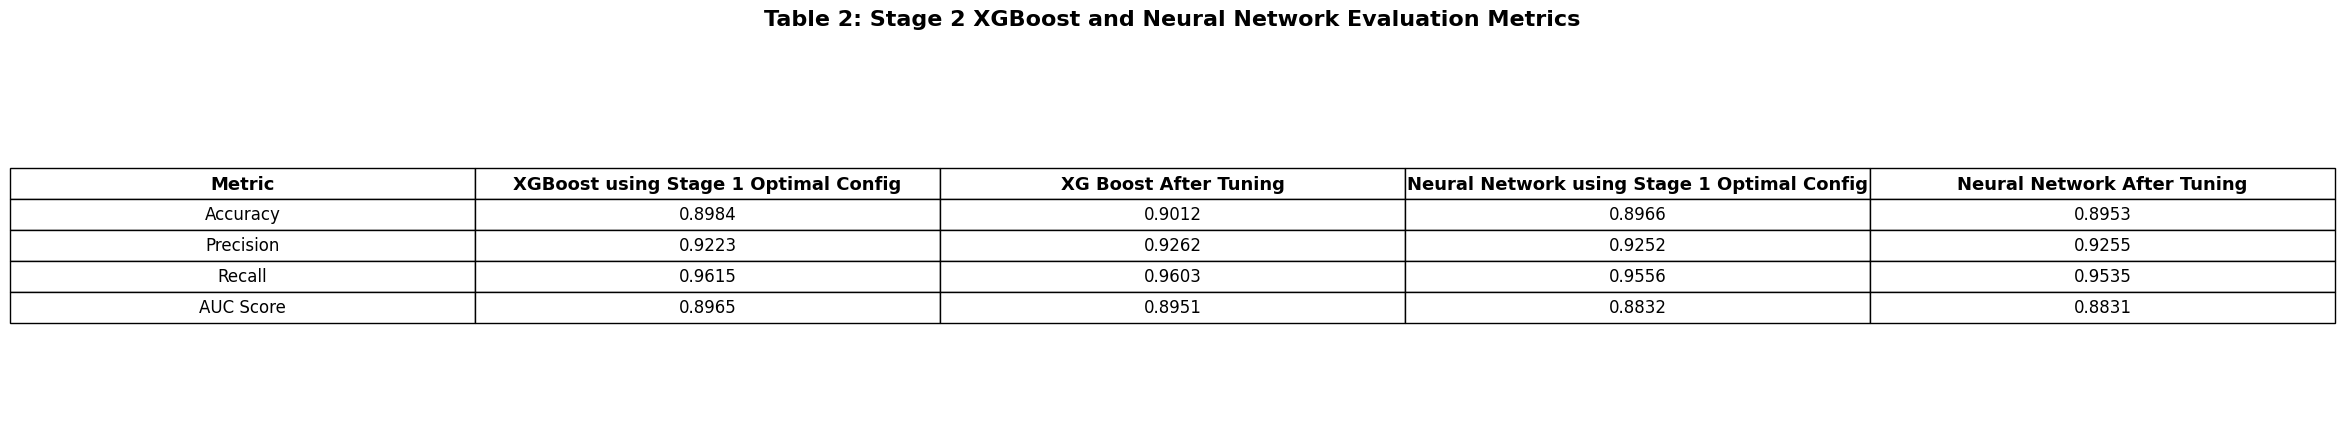

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#create table that can be exported in to report
metrics_stage2 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC Score'],
    'XGBoost using Stage 1 Optimal Config': [round(accuracy_xg_df2,4), round(precision_xg_df2,4), round(recall_xg_df2,4), round(auc_xg_df2,4)],
    'XG Boost After Tuning': [round(accuracy_tuned_xg_df2,4), round(precision_tuned_xg_df2,4), round(recall_tuned_xg_df2,4), round(auc_tuned_xg_df2,4)],
    'Neural Network using Stage 1 Optimal Config': [round(accuracy_nn_df2,4), round(precision_nn_df2,4), round(recall_nn_df2,4), round(auc_nn_df2,4)],
    'Neural Network After Tuning': [round(accuracy_tuned_nn_df2,4), round(precision_tuned_nn_df2,4), round(recall_tuned_nn_df2,4), round(auc_tuned_nn_df2,4)]
}
df_metrics_stage2 = pd.DataFrame(metrics_stage2)
fig, ax = plt.subplots(figsize=(30, 5))
ax.axis('off')

# cxreate the table
table = ax.table(
    cellText=df_metrics_stage2.values,
    colLabels=df_metrics_stage2.columns,
    loc='center',
    cellLoc='center'
)

# adjust font size and row height
table.auto_set_font_size(False)
table.set_fontsize(12)

# make column headers bold
for j in range(len(df_metrics_stage2.columns)):
    cell = table[0, j]
    cell.set_text_props(weight='bold')
    cell.set_fontsize(13)
    cell.set_height(0.08)

# adjust row height for better spacing
for i in range(1, len(df_metrics_stage2) + 1):
    for j in range(len(df_metrics_stage2.columns)):
        table[i, j].set_height(0.08)

plt.title('Table 2: Stage 2 XGBoost and Neural Network Evaluation Metrics', fontsize=16, fontweight='bold', pad=20)
save_path = '/content/metrics_stage2_table.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()
files.download(save_path)

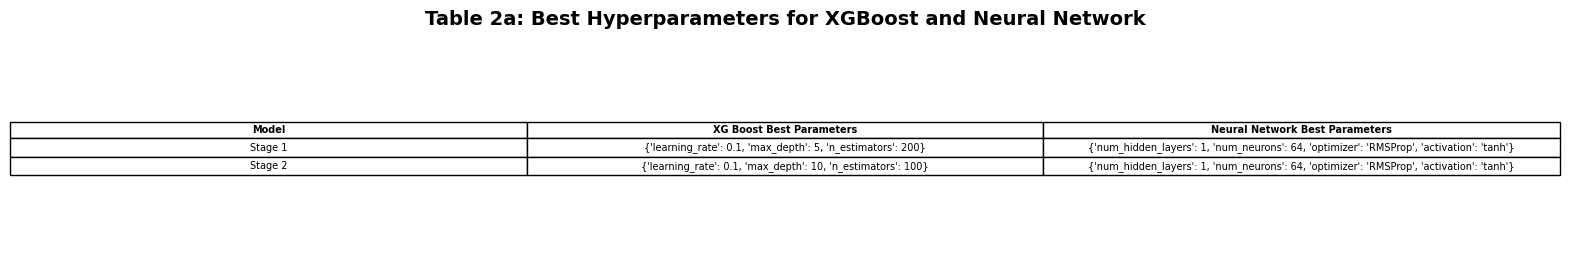

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
parameters_dict = {
    'Model': ['Stage 1', 'Stage 2'],
    'XG Boost Best Parameters': [
        str(grid_search.best_params_),
        str(grid_search_df2.best_params_)],
    'Neural Network Best Parameters': [
        str(best_params_nn),
        str(best_params_nn_df2)
    ]
}
df_best_params = pd.DataFrame(parameters_dict)
fig, ax = plt.subplots(figsize=(20, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_best_params.values, colLabels=df_best_params.columns, loc='center', cellLoc='center')

for (i, j) in zip(range(len(df_best_params.columns)), range(len(df_best_params.columns))):
    table[0, j].set_fontsize(12)
    table[0, j].set_text_props(weight='bold')

for i in range(len(df_best_params.index)):
    table[i+1, 0].set_fontsize(14)
    table[i+1, 1].set_fontsize(14)

# adjust row height for better spacing
for i in range(1, len(df_best_params) + 1):
    for j in range(len(df_best_params.columns)):
        table[i, j].set_height(0.08)

plt.title('Table 2a: Best Hyperparameters for XGBoost and Neural Network', fontsize=12, fontweight='bold')
save_path = '/content/best_params.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()
files.download(save_path)

# Stage 3 data

##3a. Data Exploration and Pre-Processing

In [13]:
# load the data - removed link for data protection purposes
df3 = pd.read_csv("")
#dropping information for data privacy reasons (for portfolio visuals only)
df3 = df3.drop(columns=['LearnerCode','HomeState','HomeCity','DateofBirth'],axis=1)

In [14]:
#load a sample of the dataset
print(df3.shape)
df3.sample(3)

(25059, 17)


,CentreName,BookingType,LeadSource,DiscountType,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
6829,ISC_Kingston,Agent,Standard Agent Booking,Bursary,Female,Indian,Foundation,International Foundation Year - International ...,False,Yes,4.0,4.0,0.0,BSc (Hons) Business Management with Business E...,Kingston University London,0.0,38.0
8627,ISC_LJMU,Direct,Digital (Web),NaN,Male,Qatari,Foundation,Business; Law and Social Studies International...,False,Yes,9.0,9.0,0.0,BA (Hons) Sociology,Liverpool John Moores University,10.0,166.0
10771,ISC_Leeds,Agent,Sponsor,Other Scholarships / Bursaries,Male,Emirati,Foundation,Science; Engineering and Computing Internation...,False,Yes,8.0,8.0,0.0,BSc (Hons) Computer Science,University of Leeds,0.0,41.0


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Assess

In [ ]:
#check for duplicate rows
duplicate_counts = df3.duplicated(keep=False).sum()
print('Duplicate rows:',duplicate_counts)

Duplicate rows: 0


In [ ]:
# convert DateofBirth to age
df3['DateofBirth'] = pd.to_datetime(df3['DateofBirth'],dayfirst=True)
df3['Age'] = (pd.Timestamp('now')-df3['DateofBirth']).dt.days//365

In [ ]:
#which columns have high cardinality
print('Columns with > 200 unique value:')
for column in df3.columns:
    if df3[column].nunique() > 200:
        print(column)

#columns with more than 50% data missing
print('\nColumns with greater than 50% of data missing:')
for column in df3.columns:
    if round(df3[column].isnull().sum()/df3[column].size*100)> 50:
        print(column)

#remove columns
df3 = df3.drop(columns=['LearnerCode','DateofBirth','HomeState','DiscountType','HomeCity','UnauthorisedAbsenceCount','ProgressionDegree'],axis=1)

Columns with > 200 unique value:
LearnerCode
DateofBirth
HomeState
HomeCity
ProgressionDegree
UnauthorisedAbsenceCount

Columns with greater than 50% of data missing:
DiscountType
HomeState


In [ ]:
#create mappings for CourseLevel
mapping = {
    'Foundation': 1,
    'International Year One': 2,
    'International Year Two': 3,
    'Pre-Masters': 4
}
df3['CourseLevel'] = df3['CourseLevel'].map(mapping)

In [ ]:
#impute the missing values for authorised absence as before
abs_by_course_gender = df3.groupby(['Gender', 'CourseLevel'])['AuthorisedAbsenceCount'].median()
df3['AuthorisedAbsenceCount'] = df3.groupby(['Gender', 'CourseLevel'], group_keys=False)['AuthorisedAbsenceCount'].apply(lambda x: x.fillna(x.median()))

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CentreName              25059 non-null  object 
 1   BookingType             25059 non-null  object 
 2   LeadSource              25059 non-null  object 
 3   Gender                  25059 non-null  object 
 4   Nationality             25059 non-null  object 
 5   CourseLevel             25059 non-null  int64  
 6   CourseName              25059 non-null  object 
 7   IsFirstIntake           25059 non-null  bool   
 8   CompletedCourse         25059 non-null  object 
 9   AssessedModules         22828 non-null  float64
 10  PassedModules           22828 non-null  float64
 11  FailedModules           22828 non-null  float64
 12  ProgressionUniversity   25059 non-null  object 
 13  AuthorisedAbsenceCount  25059 non-null  float64
 14  Age                     25059 non-null

In [ ]:
print('Percent of dataset missing per feature')
round(df3[['AssessedModules','PassedModules','FailedModules']].isnull().sum()/25059*100,2)

Percent of dataset missing per feature


,0
AssessedModules,8.9
PassedModules,8.9
FailedModules,8.9


Text(0.5, 1.0, 'Distribution of Assessed Modules')

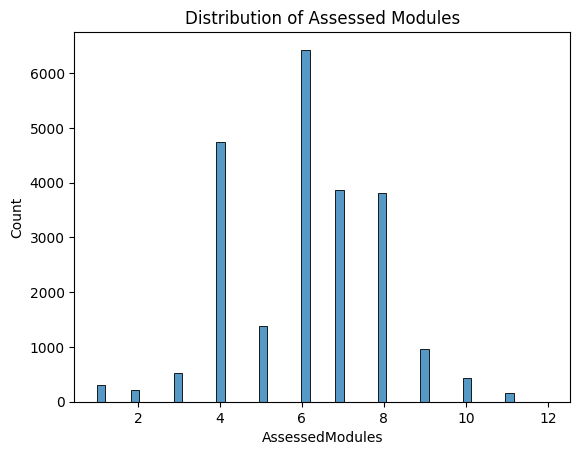

In [ ]:
#view distribution of assessed modules
sns.histplot(df3['AssessedModules'])
plt.title('Distribution of Assessed Modules')

In [ ]:
#given missing values are greater than 5% of the dataset, we will need to impute them
# firstly, assessed modules, presumably this is roughly consistent per course
df3.groupby('CourseName')['AssessedModules'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

,AssessedModules
CourseName,
Accelerated International Foundation Year - Business; Economics; Accounting and Finance,7.0
Accelerated International Foundation Year - Engineering; Physical Science and Computer Science,7.0
Accelerated Pre-Masters,4.0
Accelerated Pre-Masters Programme Business; Humanities; Social Sciences and Law (ICAS),3.0
Accelerated Pre-Masters Programme Computing; Engineering and Health Sciences (ICAS),3.0
...,...
Science and Engineering Pre-Masters (ICAS),4.0
Science; Engineering and Computing Foundation Year,10.0
Science; Engineering and Computing International Foundation Year,8.0


In [ ]:
#when initially trying to impute using the above, I came across errors,
# this is to find out which course has no modal values and impute using the median of the course level instead
# loop over the groups and check where mode() returns an empty series
for name, group in df3.groupby('CourseName'):
    mode_value = group['AssessedModules'].mode()

    # if there's no mode, use the median of the CourseLevel for filling
    if mode_value.empty:
        print(f"Group '{name}' has no mode (all NaN or other reasons):")
        df3.loc[group.index, 'AssessedModules'] = group['AssessedModules'].fillna(
            df3.groupby('CourseLevel')['AssessedModules'].median().get(group['CourseLevel'].iloc[0], None)
        )
    else:
        # If a mode exists, fill missing values in this group using the mode
        mode_value = mode_value.iloc[0]
        df3.loc[group.index, 'AssessedModules'] = group['AssessedModules'].fillna(mode_value)


Group 'CertHE International Foundation and Year One with Business (ICAS)' has no mode (all NaN or other reasons):


In [ ]:
#check the imputation worked
df3['AssessedModules'].isnull().sum()

np.int64(0)

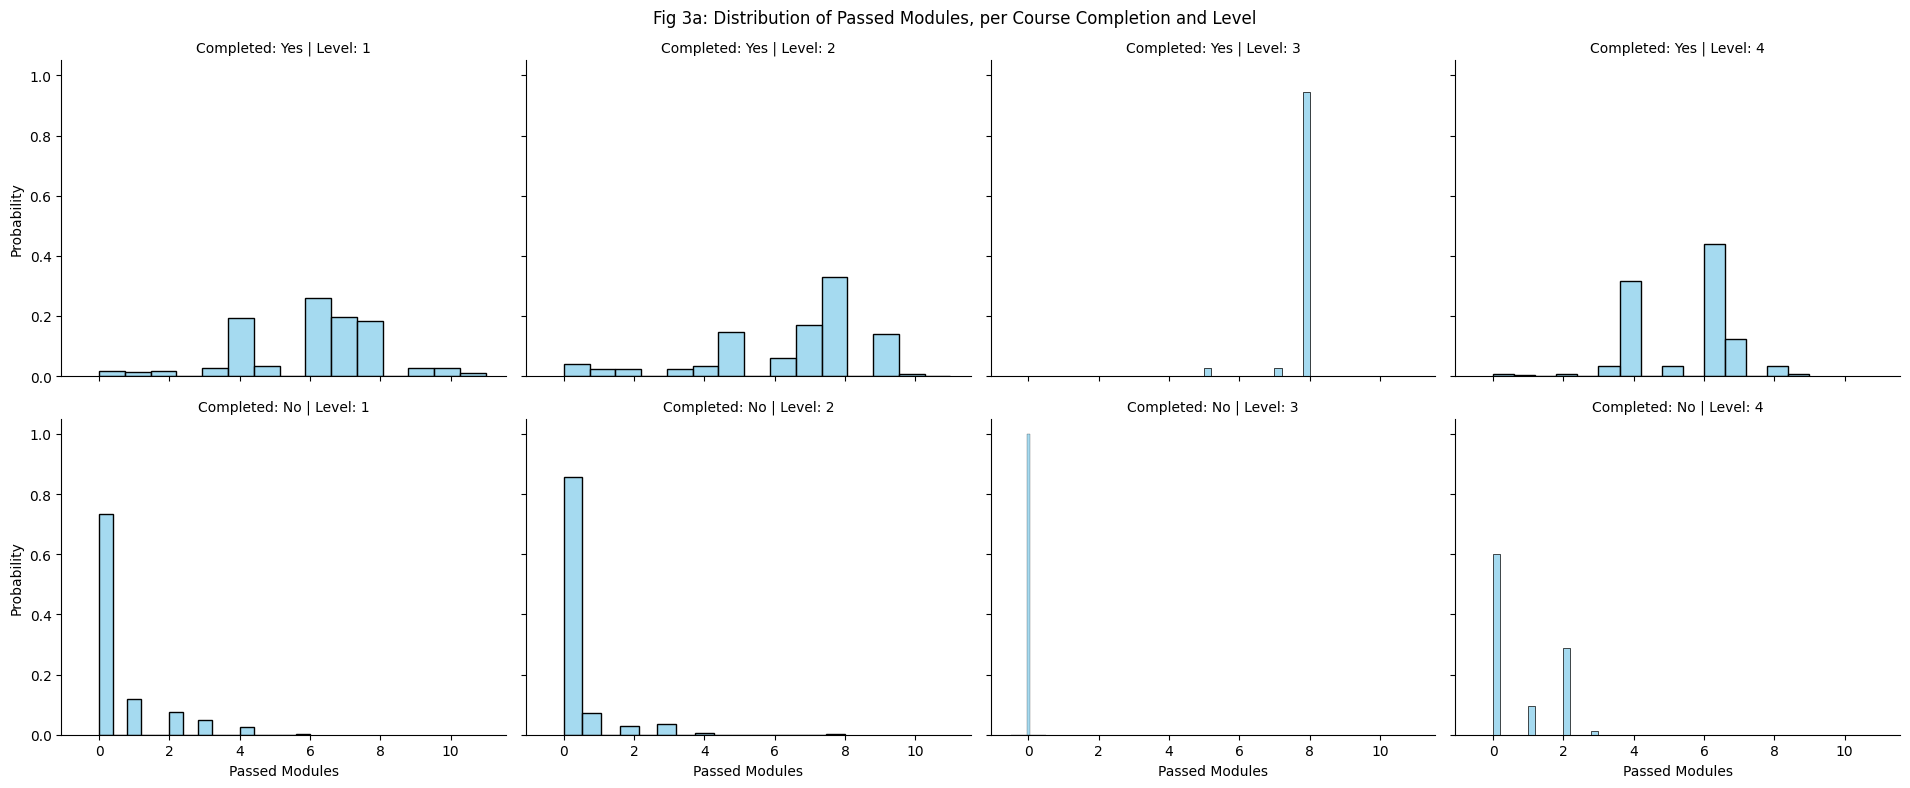

In [ ]:
#view the distribution of passedmodules per courselevel and whether each student completed the course
g = sns.FacetGrid(df3, col="CourseLevel", row="CompletedCourse", height=4, aspect=1.2)

# plot the histogram
g.map_dataframe(
    sns.histplot,
    x="PassedModules",
    stat="probability",
    bins=15,
    color='skyblue'
)

# Add axis labels and titles
g.set_axis_labels("Passed Modules", "Probability")
g.set_titles(row_template="Completed: {row_name}", col_template="Level: {col_name}")
plt.suptitle('Fig 3a: Distribution of Passed Modules, per Course Completion and Level')
plt.tight_layout()
plt.show()

In [ ]:
#impute values for AssessedModules based on the median value
df3['PassedModules'] = df3.groupby(['CourseLevel','CompletedCourse'], group_keys=False)['PassedModules'].apply(lambda x: x.fillna(x.median()))
#check imputation worked
df3['PassedModules'].isnull().sum()

np.int64(0)

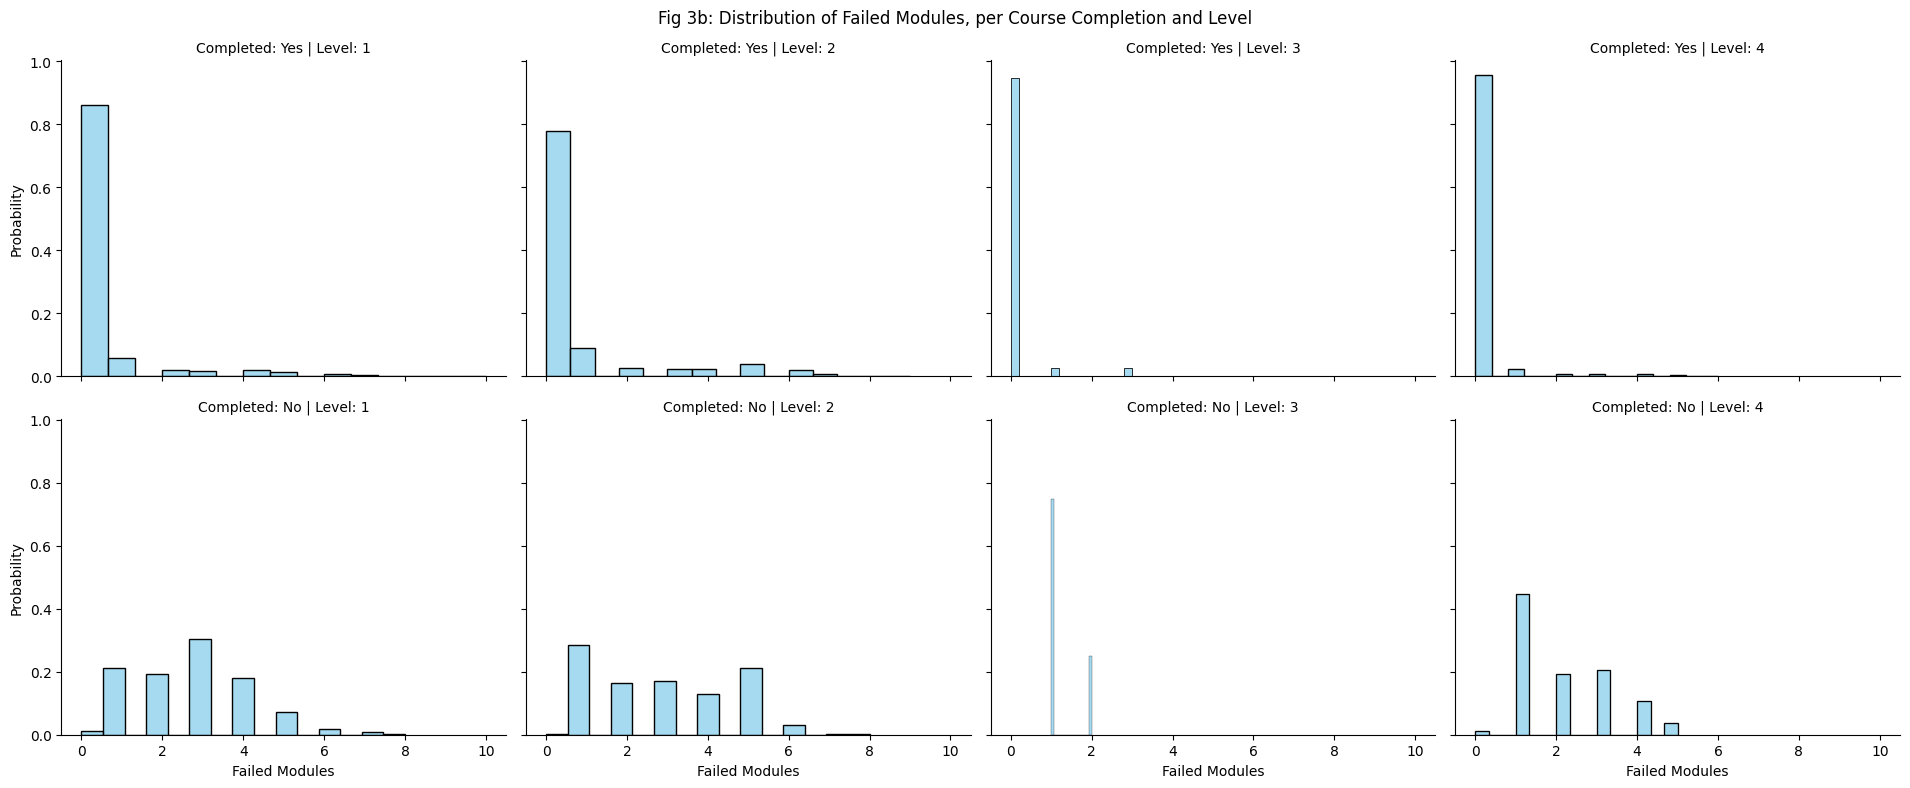

In [ ]:
#view the distribution of passedmodules per courselevel and whether each student completed the course
g = sns.FacetGrid(df3, col="CourseLevel", row="CompletedCourse", height=4, aspect=1.2)

# plot the histogram
g.map_dataframe(
    sns.histplot,
    x="FailedModules",
    stat="probability",
    bins=15,
    color='skyblue'
)

# Add axis labels and titles
g.set_axis_labels("Failed Modules", "Probability")
g.set_titles(row_template="Completed: {row_name}", col_template="Level: {col_name}")
plt.suptitle('Fig 3b: Distribution of Failed Modules, per Course Completion and Level')
plt.tight_layout()
plt.show()

In [ ]:
#use the same logic as for assessed modules to impute the missing values
df3['FailedModules'] = df3.groupby(['CourseLevel','CompletedCourse'], group_keys=False)['FailedModules'].apply(lambda x: x.fillna(x.median()))
#check imputation worked
df3['FailedModules'].isnull().sum()

np.int64(0)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CentreName              25059 non-null  object 
 1   BookingType             25059 non-null  object 
 2   LeadSource              25059 non-null  object 
 3   Gender                  25059 non-null  object 
 4   Nationality             25059 non-null  object 
 5   CourseLevel             25059 non-null  int64  
 6   CourseName              25059 non-null  object 
 7   IsFirstIntake           25059 non-null  bool   
 8   CompletedCourse         25059 non-null  object 
 9   AssessedModules         25059 non-null  float64
 10  PassedModules           25059 non-null  float64
 11  FailedModules           25059 non-null  float64
 12  ProgressionUniversity   25059 non-null  object 
 13  AuthorisedAbsenceCount  25059 non-null  float64
 14  Age                     25059 non-null

In [ ]:
#one hot encode the remaining categorical columns
df3 = pd.get_dummies(df3,
                      columns = ['CentreName','BookingType','LeadSource','CourseName','IsFirstIntake','CompletedCourse','ProgressionUniversity','Nationality','Gender'],
                      drop_first=True).astype(int)

In [ ]:
df3.describe()

,CourseLevel,AssessedModules,PassedModules,FailedModules,AuthorisedAbsenceCount,Age,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,CentreName_ISC_Huddersfield,CentreName_ISC_Kingston,CentreName_ISC_LJMU,CentreName_ISC_Lancaster,CentreName_ISC_Leeds,CentreName_ISC_Lincoln,CentreName_ISC_London,CentreName_ISC_Online,CentreName_ISC_RHUL,CentreName_ISC_Sheffield,CentreName_ISC_Strathclyde,CentreName_ISC_Surrey,CentreName_ISC_Sussex,CentreName_ISC_Teesside,BookingType_Direct,LeadSource_Digital (Web),LeadSource_Re-enrolment,LeadSource_Referrals,LeadSource_Sponsor,LeadSource_Standard Agent Booking,LeadSource_Walk-in,CourseName_Accelerated International Foundation Year - Engineering; Physical Science and Computer Science,CourseName_Accelerated Pre-Masters,CourseName_Accelerated Pre-Masters Programme Business; Humanities; Social Sciences and Law (ICAS),CourseName_Accelerated Pre-Masters Programme Computing; Engineering and Health Sciences (ICAS),CourseName_Arts; Humanities; Law and Social Sciences - International Foundation Year,CourseName_Arts; Humanities; Law and Social Sciences International Foundation Year,CourseName_Business Management and Finance International Year Two,CourseName_Business Management and Finance International Year Two (ICAS),CourseName_Business and Law Pre-Masters,CourseName_Business and Law Pre-Masters (ICAS),CourseName_Business and Management Foundation Year (taught at the Holland ISC; in Amsterdam),CourseName_Business and Management Pre-Masters,CourseName_Business and Management Pre-Masters (January intake),CourseName_Business and Management Pre-Masters - ICAS,CourseName_Business and Management Studies Foundation Year,CourseName_Business and Media Foundation Year,CourseName_Business and Social Sciences Pre-Masters,CourseName_Business and Social Sciences Undergraduate Foundation Programme,CourseName_Business; Economics and Finance Foundation Year,CourseName_Business; Economics and Finance Foundation Year (Sponsored),CourseName_Business; Economics and Social Sciences Foundation Year,CourseName_Business; Economics; Accounting and Finance - International Foundation Year,CourseName_Business; Economics; Accounting and Finance International Foundation Year,CourseName_Business; Economics; Accounting and Finance Pre-Masters,CourseName_Business; Economics; Accounting and Real Estate Undergraduate Foundation Programme,CourseName_Business; Economics; Law and Social Sciences International Foundation Year,CourseName_Business; Law and Social Sciences Pre-Masters,CourseName_Business; Law and Social Studies International Foundation Year,CourseName_Business; Law and Social Studies International Foundation Year (November Intake),CourseName_Business; Management & Law Pre Masters - iCAS,CourseName_Business; Management; Accounting and Finance Foundation Year,CourseName_Business; Management; Accounting and Finance International Foundation Year,CourseName_Business; Management; Accounting and Finance International Year One,CourseName_Business; Management; Accounting and Finance Pre Masters,CourseName_Business; Management; Accounting and Finance Pre-Masters,CourseName_Business; Social Sciences and Humanities Foundation Year,CourseName_Business; Social Sciences and Humanities Pre-Masters,CourseName_Business; Social Sciences and Humanities Pre-Masters (2.5 Semesters),CourseName_CertHE International Foundation and Year One with Business (ICAS),CourseName_Computing Science International Year Two (ICAS),CourseName_Computing; Engineering and Physical Sciences International Foundation Year,CourseName_Engineering & Computing Pre Masters - iCAS,CourseName_Engineering Pre-Masters,CourseName_Engineering Pre-Masters (2.5 Semesters),CourseName_Engineering and Computing Foundation Year,CourseName_Engineering and Sciences Foundation Year,CourseName_Engineering and Sciences Foundation Year (Sponsored),CourseName_Engineering and Sciences Pre-Masters,CourseName_Engineering and Sciences Undergraduate Foundation P

In [ ]:
X3 = df3.drop(columns=['CompletedCourse_Yes'])
y3 = df3['CompletedCourse_Yes']

##3b. XGBoost Module

In [ ]:
print("Best Parameters in Stage 2 following Tuning:", grid_search_df2.best_params_)

Best Parameters in Stage 2 following Tuning: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


In [ ]:
#split the dataset using the new df with extra column
X3_train_full, X3_test, y3_train_full, y3_test = train_test_split(X3, y3, stratify=y3, test_size=0.2, random_state=42)
#run the xg boost model with best parameters from the previous stage on the new df
xg_model_df3 = xgb.XGBClassifier(**grid_search_df2.best_params_, random_state=42)
xg_model_df3.fit(X3_train_full, y3_train_full)

#create the predictions
y3_pred = xg_model_df3.predict(X3_test)
y3_proba = xg_model_df3.predict_proba(X3_test)[:, 1]  # Probabilities for class 1

#evaluation metrics and scores
accuracy_xg_df3 = accuracy_score(y3_test, y3_pred)
precision_xg_df3 = precision_score(y3_test, y3_pred)
recall_xg_df3 = recall_score(y3_test, y3_pred)
auc_xg_df3 = roc_auc_score(y3_test, y3_proba)

# compare performance of stage 2 model vs model using stage 3 data
print(f"Accuracy:\nStage 2: {accuracy_xg_df2:.4f}, Stage 3: {accuracy_xg_df3:.4f}")
if accuracy_xg_df2 > accuracy_xg_df3:
    print("Stage 2 model is more accurate")
else:
    print("Improved accuracy using stage 3 data")
print(f"\nPrecision:\nStage 2: {precision_xg_df2:.4f}, Stage 3: {precision_xg_df3:.4f}")
if precision_xg_df2 > precision_xg_df3:
    print("Stage 2 model achieves a higher precision metric")
else:
    print("Improved precision using stage 3 data")
print(f"\nRecall:\nStage 2: {recall_xg_df2:.4f}, Stage 3: {recall_xg_df3:.4f}")
if recall_xg_df2 > recall_xg_df3:
    print("Stage 2 model achieves a higher recall metric")
else:
    print("Improved recall using stage 3 data")
print(f"\nAUC Score:\nStage 2: {auc_xg_df2:.4f}, Stage 3: {auc_xg_df3:.4f}")
if auc_xg_df2 > auc_xg_df3:
    print("Stage 2 model achieves a higher AUC score")
else:
    print("Improved AUC score using stage 3 data")


Accuracy:
Stage 2: 0.8984, Stage 3: 0.9904
Improved accuracy using stage 3 data

Precision:
Stage 2: 0.9223, Stage 3: 0.9934
Improved precision using stage 3 data

Recall:
Stage 2: 0.9615, Stage 3: 0.9953
Improved recall using stage 3 data

AUC Score:
Stage 2: 0.8965, Stage 3: 0.9991
Improved AUC score using stage 3 data


##3c. Neural Network

In [ ]:
# run the neural network with the tuned parameters in stage 2, on the stage 3 dataset
print('Tuned best parameters in stage 2:',best_params_nn_df2)

Tuned best parameters in stage 2: {'num_hidden_layers': 1, 'num_neurons': 64, 'optimizer': 'RMSProp', 'activation': 'tanh'}


In [ ]:
set_seed = np.random.seed(42)
tf.random.set_seed(42)

# split the training and test set further to get validation sets, with an 80/20 split, using the new dataset
X3_train, X3_val, y3_train, y3_val = train_test_split(X3_train_full, y3_train_full, stratify=y3_train_full, test_size=0.2, random_state=42)


scaler3 = StandardScaler()
X3_train_scaled = scaler3.fit_transform(X3_train)
X3_val_scaled = scaler3.transform(X3_val)
X3_test_scaled = scaler3.transform(X3_test)

#set early stopping criteria to save training time and computational cost
early_stopping3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#create and fit the model using the best parameters found in stage 2, using stage 3 data
nn_model_df3 = Sequential()
nn_model_df3.add(Input(shape=(X3_train_scaled.shape[1],)))
nn_model_df3.add(Dense(32, activation='tanh'))
nn_model_df3.add(Dense(32, activation='tanh'))
nn_model_df3.add(Dense(32, activation='tanh'))
nn_model_df3.add(Dense(1, activation='sigmoid'))
nn_model_df3.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])
nn_model_df3.fit(X3_train_scaled, y3_train,
                 validation_data=(X3_val_scaled, y3_val),
                 epochs=30,
                 batch_size=32,
                 callbacks=[early_stopping3],
                 verbose=0)

#create the predictions
y3_proba_nn = nn_model_df3.predict(X3_test_scaled).ravel()
y3_pred_nn = (y3_proba_nn >= 0.5).astype(int)

#evaluation metrics and scores
accuracy_nn_df3 = accuracy_score(y3_test, y3_pred_nn)
precision_nn_df3 = precision_score(y3_test, y3_pred_nn)
recall_nn_df3 = recall_score(y3_test, y3_pred_nn)
auc_nn_df3 = roc_auc_score(y3_test, y3_proba_nn)


# compare performance of stage 2 model vs model using stage 3 data
print(f"Accuracy:\nStage 2: {accuracy_nn_df2:.4f}, Stage 3: {accuracy_nn_df2:.4f}")
if accuracy_nn_df2 > accuracy_nn_df3:
    print("Stage 2 model is more accurate")
else:
    print("Improved accuracy using stage 3 data")
print(f"\nPrecision:\nStage 2: {precision_nn_df2:.4f}, Stage 3: {precision_nn_df3:.4f}")
if precision_nn_df2 > precision_nn_df3:
    print("Stage 2 model achieves a higher precision metric")
else:
    print("Improved precision using stage 3 data")
print(f"\nRecall:\nStage 2: {recall_nn_df2:.4f}, Stage 3: {recall_nn_df3:.4f}")
if recall_nn_df2 > recall_xg_df3:
    print("Stage 2 model achieves a higher recall metric")
else:
    print("Improved recall using stage 3 data")
print(f"\nAUC Score:\nStage 2: {auc_nn_df2:.4f}, Stage 3: {auc_nn_df3:.4f}")
if auc_nn_df2 > auc_nn_df3:
    print("Stage 2 model achieves a higher AUC score")
else:
    print("Improved AUC score using stage 3 data")


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy:
Stage 2: 0.8966, Stage 3: 0.8966
Improved accuracy using stage 3 data

Precision:
Stage 2: 0.9252, Stage 3: 0.9897
Improved precision using stage 3 data

Recall:
Stage 2: 0.9556, Stage 3: 0.9904
Improved recall using stage 3 data

AUC Score:
Stage 2: 0.8832, Stage 3: 0.9968
Improved AUC score using stage 3 data


#Evaluation

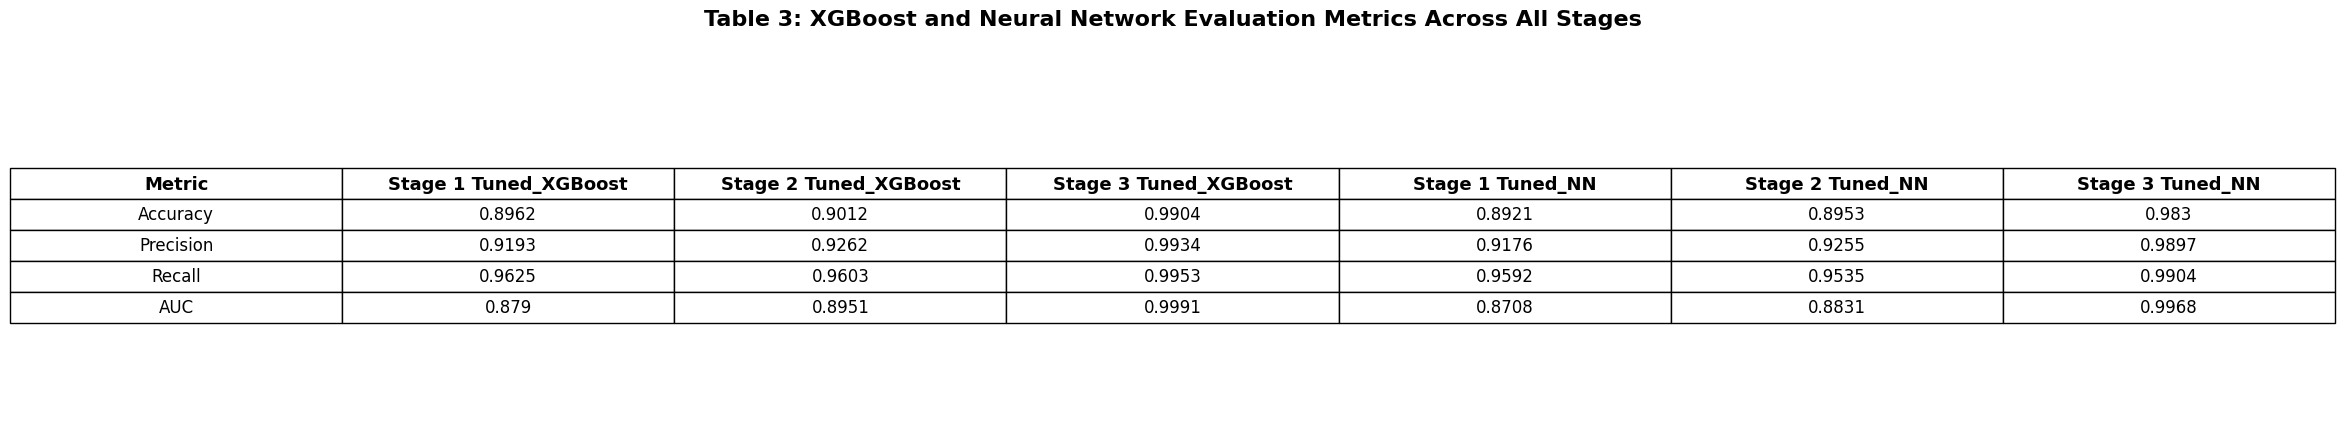

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#compile results in an easy to read format for stage 1 and stage 2 and stage 3, following tuning
metrics_df_xg = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC'],
    'Stage 1 Tuned': [round(accuracy_tuned,4), round(precision_tuned,4), round(recall_tuned,4), round(auc_tuned,4)],
    'Stage 2 Tuned': [round(accuracy_tuned_xg_df2,4), round(precision_tuned_xg_df2,4), round(recall_tuned_xg_df2,4), round(auc_tuned_xg_df2,4)],
    'Stage 3 Tuned': [round(accuracy_xg_df3,4), round(precision_xg_df3,4), round(recall_xg_df3,4), round(auc_xg_df3,4)]
})
#compile results in an easy to read format for stage 1, stage 2 and stage 3, following tuning
metrics_df_nn = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC'],
    'Stage 1 Tuned': [round(accuracy_tuned_nn,4), round(precision_tuned_nn,4), round(recall_tuned_nn,4), round(auc_tuned_nn,4)],
    'Stage 2 Tuned': [round(accuracy_tuned_nn_df2,4), round(precision_tuned_nn_df2,4), round(recall_tuned_nn_df2,4), round(auc_tuned_nn_df2,4)],
    'Stage 3 Tuned': [round(accuracy_nn_df3,4), round(precision_nn_df3,4), round(recall_nn_df3,4), round(auc_nn_df3,4)]
})
merged_metrics = pd.merge(metrics_df_xg, metrics_df_nn, on='Metric', suffixes=('_XGBoost', '_NN'))
fig, ax = plt.subplots(figsize=(30, 5))
ax.axis('off')

# cxreate the table
table = ax.table(
    cellText=merged_metrics.values,
    colLabels=merged_metrics.columns,
    loc='center',
    cellLoc='center'
)

# adjust font size and row height
table.auto_set_font_size(False)
table.set_fontsize(12)

# make column headers bold
for j in range(len(merged_metrics.columns)):
    cell = table[0, j]
    cell.set_text_props(weight='bold')
    cell.set_fontsize(13)
    cell.set_height(0.08)

# adjust row height for better spacing
for i in range(1, len(merged_metrics) + 1):
    for j in range(len(merged_metrics.columns)):
        table[i, j].set_height(0.08)

plt.title('Table 3: XGBoost and Neural Network Evaluation Metrics Across All Stages', fontsize=16, fontweight='bold', pad=20)
save_path = '/content/metrics_stage3_table.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()
files.download(save_path)

The results are different across every stage, showing the additional features improve model performance. XGBoost always performs better than the neural network, suggesting for this model that XGBoost should be used.